In [108]:
from skimage import io,morphology as m,filters,feature
import matplotlib.pyplot as plt
import numpy as np


In [315]:
def t1(A):
    fig,ax=plt.subplots(1,3,figsize=(10,3))
    ax[0].imshow(A,cmap='gray')
    ax[0].set_axis_off()
    
    e=m.erosion(A,m.diamond(4))
    ax[1].imshow(e,cmap='gray')
    ax[1].set_axis_off()
    
    clear=m.remove_small_holes(e,64)
    clear=(255*clear).astype('uint8')
    ax[2].imshow(clear,cmap='gray')
    ax[2].set_axis_off()
    
    return clear

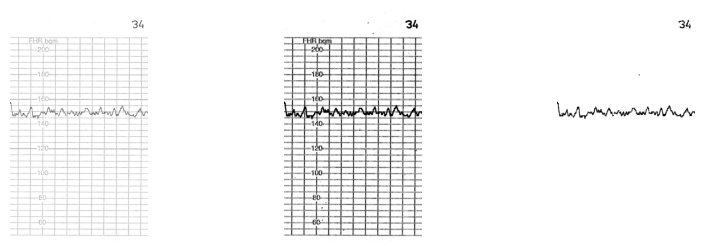

In [316]:
A=io.imread('./train/D1.jpg')
A=A[:,:,0]
_=t1(A)

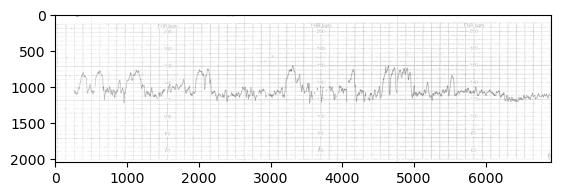

In [317]:
B=io.imread('./test/final_1.jpeg')
B=B[:,:,0]
plt.imshow(B,cmap='gray')

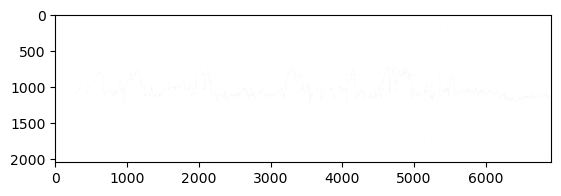

In [427]:
mask=B==0
plt.imshow(1-mask,cmap='gray')

In [436]:
plt.imsave('hola.jpeg',e,cmap='gray')

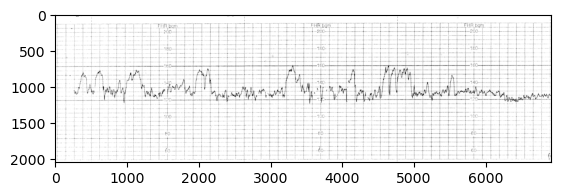

In [435]:
e=m.opening(B,m.diamond(3))
plt.imshow(e,cmap='gray')


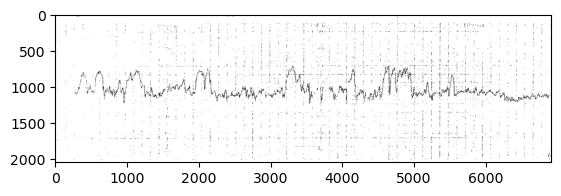

In [420]:
o=m.closing(e,m.diamond(4))
plt.imshow(o,cmap='gray')

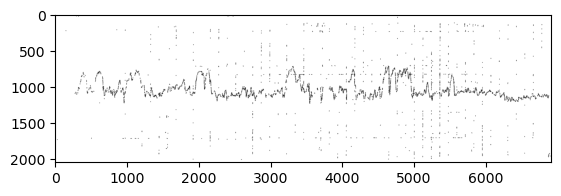

In [421]:
f=m.remove_small_holes(e,64)
f=(255*f).astype('uint8')
plt.imshow(f,cmap='gray')

In [437]:
f

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

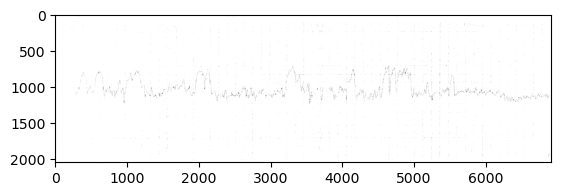

In [423]:
plt.imshow(m.dilation(o,m.diamond(3)),cmap='gray')